In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.set_printoptions(precision=10)
np.set_printoptions(suppress=True)

In [3]:
append       = np.append
arange       = np.arange
array        = np.array
diff         = np.diff
exp          = np.exp
fromfunction = np.fromfunction
linspace     = np.linspace
rint         = np.rint
sqrt         = np.sqrt

solve_linear = np.linalg.solve

#### Parte 1:

In [4]:
def AdamsBash_Coefficients(order):
    
    M = fromfunction(lambda i, j: j**i, (order, order))
    
    v = fromfunction(lambda i: (-1)**i/(i+1), (order,))
    
    return solve_linear(M,v)

In [5]:
[print(f"Order {order} → Coefficients : {AdamsBash_Coefficients(order)}") for order in range(1,5)];

Order 1 → Coefficients : [1.]
Order 2 → Coefficients : [ 1.5 -0.5]
Order 3 → Coefficients : [ 1.9166666667 -1.3333333333  0.4166666667]
Order 4 → Coefficients : [ 2.2916666667 -2.4583333333  1.5416666667 -0.375       ]


In [6]:
def RK4_Initializer(order, u0, f, h, extra_precision=1):
    
    # The extra_precision is a positive integer that allows the initializer to use a smaller stepsize.
    # e.g. if extra_precision = 2, then the initializer stepsize is set to be (h/2).
    
    h /= extra_precision
    
    Initializer = array([u0])
    
    t = 0
    for step in range((order-1) * extra_precision):
        
        u = Initializer[-1]
        
        k1 = h * f(t, u)
        k2 = h * f(t+h/2, u+k1/2)
        k3 = h * f(t+h/2, u+k2/2)
        k4 = h * f(t+h, u+k3)
        
        Initializer = append(Initializer, u + (1/6)*(k1 + 2*k2 + 2*k3 + k4))
        
        t += h
    
    return Initializer[::extra_precision]

In [7]:
def AdamsBash_Solver(order, u0, f, h, t_final):
    
    Coeffs = AdamsBash_Coefficients(order)
    
    T = linspace(0, (order-1)*h, order)
    
    U = RK4_Initializer(order, u0, f, h)

    t = T[-1]
    while(t < t_final):

        u = U[-1]

        U = append(U, u + h*(Coeffs @ f(T[::-1][:order],U[::-1][:order])))

        t += h
        
        T = append(T,t)

    return U

In [8]:
def f(t, u):
    
    return 10 * exp((-1/2)*((t-2)/(0.075))**2) - 0.6*u

In [9]:
u0      = 0.5
h       = 1e-3
t_final = 4

In [10]:
U3 = AdamsBash_Solver(3, u0, f, h, t_final)

In [11]:
U4 = AdamsBash_Solver(4, u0, f, h, t_final)

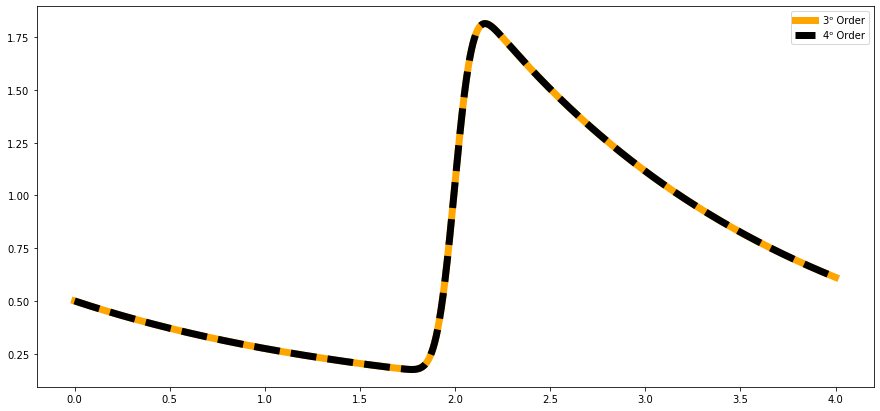

In [12]:
plt.figure(figsize=(15,7))

T = linspace(0,t_final,len(U3))

plt.plot(T,U3,'orange', linewidth=7, label='3ᵒ Order');
plt.plot(T,U4,'k--', linewidth=7, label='4ᵒ Order');

plt.legend();

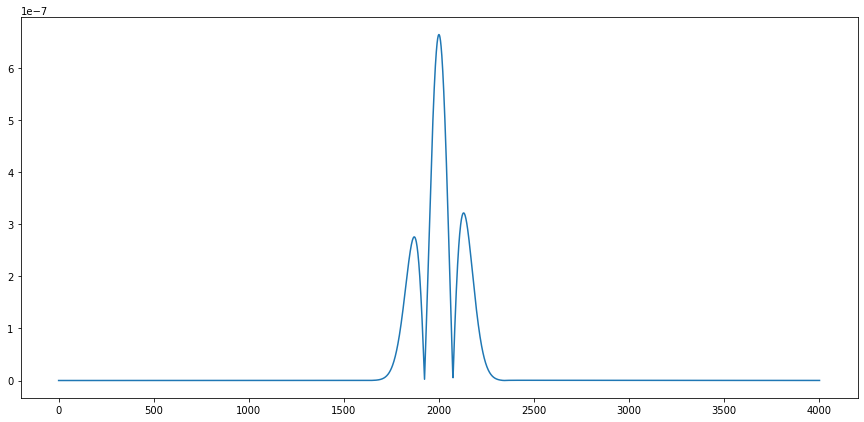

In [13]:
# Difference between 3ᵒ and 4ᵒ orders

plt.figure(figsize=(15,7))
plt.plot(abs(U3-U4));

#### Parte 2:

In [14]:
def Linear_Interpolation(X, A, B):
    
    first = B[0]
    
    for i in range(1, len(A)+1):
        
        a = A[-i]

        if(a <= first):
            
            first_i = len(A)-i
            break
    
    i = first_i
    
    Y = []
    for b in B:
        
        for j in range(i, len(A)-1):
            
            a  = A[j]
            aa = A[j+1]
            
            if(a <= b and b <= aa): 
                
                Y.append(X[j] + (X[j+1]-X[j])*((b-a)/(aa-a)))
                
                i = j
                
                break

    return array(Y)

In [15]:
print(Linear_Interpolation([0, 1, 2, 3], [0, 2, 4, 6], [1, 3, 5]))

[0.5 1.5 2.5]


In [16]:
def AdamsBash_Adaptative_Solver(order_p, order_q, u0, f, h, t_final):
    
    if(order_p == order_q): 
        
        return AdamsBash_Solver(order_p, u0, f, h, t_final)
    
    Coeffs_p = AdamsBash_Coefficients(order_p)
    Coeffs_q = AdamsBash_Coefficients(order_q)
    
    O = max(order_p, order_q)
    
    T = linspace(0, (O-1)*h, O)
    
    U = RK4_Initializer(O, u0, f, h)

    max_delta = 1e-07
    min_delta = 1e-15
    
    base_h = h
    
    t = T[-1]
    while(t <= t_final):
        
        base_T_p = array([t - i*base_h for i in range(O)][:order_p][::-1])
        base_T_q = array([t - i*base_h for i in range(O)][:order_q][::-1])
        
        base_U_p = Linear_Interpolation(U, T, base_T_p)
        base_U_q = Linear_Interpolation(U, T, base_T_q)
        
        base_u_p = U[-1] + base_h*(Coeffs_p @ f(base_T_p[::-1], base_U_p[::-1]))
        base_u_q = U[-1] + base_h*(Coeffs_q @ f(base_T_q[::-1], base_U_q[::-1]))
        
        delta = abs(base_u_p - base_u_q)
        
        if(delta > max_delta): delta = max_delta
        if(delta < min_delta): delta = min_delta
            
        adapt = (1 + (delta - min_delta)/(max_delta-min_delta))
        
        h = base_h / adapt
        
        T_p = array([t - i*h for i in range(O)][:order_p][::-1])
        T_q = array([t - i*h for i in range(O)][:order_q][::-1])
        
        U_p = Linear_Interpolation(U, T, T_p)
        U_q = Linear_Interpolation(U, T, T_q)

        u_p = U[-1] + h*(Coeffs_p @ f(T_p[::-1], U_p[::-1]))
        u_q = U[-1] + h*(Coeffs_q @ f(T_q[::-1], U_q[::-1]))

        t += h

        T = append(T,t)
        
        if(order_q > order_p):
            
            U = append(U, u_q)
            
        else:
            
            U = append(U, u_p)
            
    
    return T, U

In [17]:
order_p = 3
order_q = 4

In [18]:
T, U = AdamsBash_Adaptative_Solver(order_p, order_q, u0, f, h, t_final)

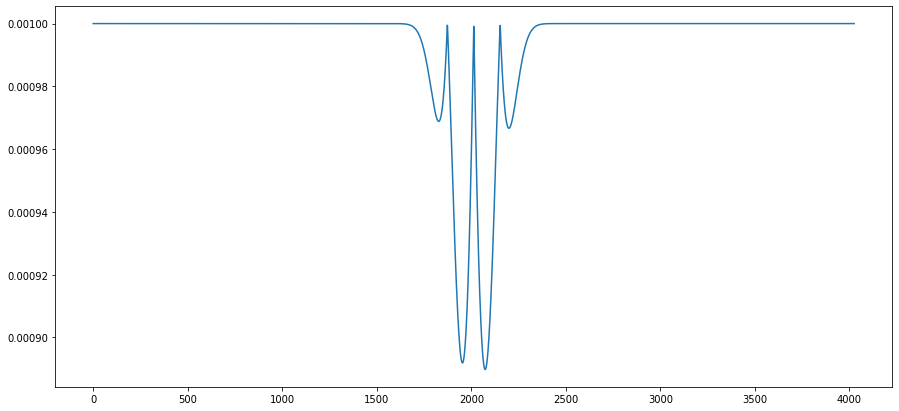

In [19]:
# Stepsizes throughout the adaptative solver

plt.figure(figsize=(15,7))
plt.plot(diff(T));

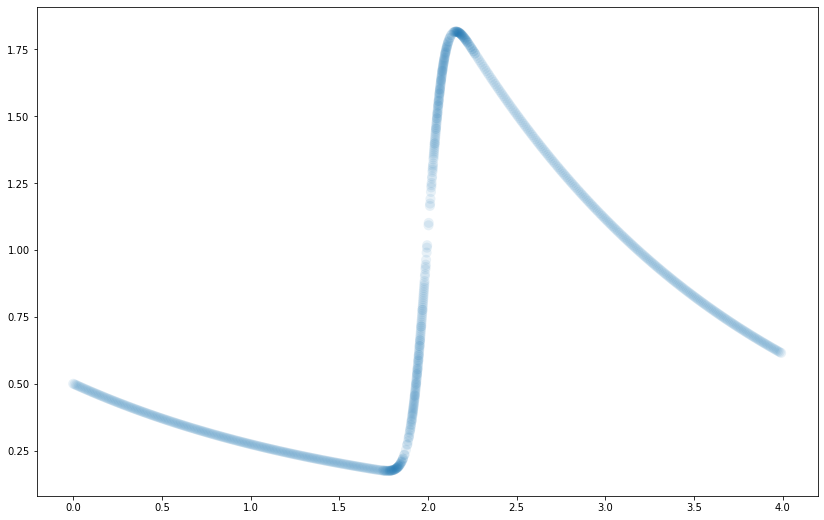

In [20]:
# Adapted concentration of points 

S = diff(T)
S = (S - S.min())/(S.max()-S.min())

Idx_S = np.round(np.linspace(0, len(S) - 1, 500)).astype(int)

Concentrated_Indexes = array([]).astype(np.int)

for j, idx_S in enumerate(Idx_S[:-1]):

    s = S[idx_S]
    
    y = int(rint(-9*s + 10))
    
    L = arange(Idx_S[j], Idx_S[j+1])
    
    idx = np.round(np.linspace(0, len(L) - 1, y)).astype(int) + Idx_S[j]
    
    Concentrated_Indexes = append(Concentrated_Indexes, idx)
    
Concentrated_Indexes = Concentrated_Indexes[Concentrated_Indexes < len(T)-1]


plt.figure(figsize=(14,9))
plt.scatter(T[Concentrated_Indexes], U[Concentrated_Indexes],alpha=0.1, edgecolors='none',s=100);